In [1]:
import cellestial as cl
import scanpy as sc


from lets_plot import *

import polars as pl

LetsPlot.setup_html()


data = sc.read("data/pbmc3k_pped.h5ad")

In [2]:
dimensions = "umap"
key = "leiden"
cluster_name = "Cluster"
barcode_name = "CellID"

frame = pl.from_numpy(
    data.obsm[f"X_{dimensions}"][:, :2], schema=[f"{dimensions}1", f"{dimensions}2"]
).with_columns(pl.Series(barcode_name, data.obs_names))


frame = frame.with_columns(
    pl.Series(barcode_name, data.obs_names), pl.Series(cluster_name, data.obs[key])
)

In [3]:
umap = cl.dimensional(data)

In [4]:
frame

shape: (16_680, 4)
┌───────────┬───────────┬────────────────────┬─────────┐
│ umap1     ┆ umap2     ┆ CellID             ┆ Cluster │
│ ---       ┆ ---       ┆ ---                ┆ ---     │
│ f32       ┆ f32       ┆ str                ┆ cat     │
╞═══════════╪═══════════╪════════════════════╪═════════╡
│ 15.643094 ┆ 7.585866  ┆ AAACCCAAGGATGGCT-1 ┆ 0       │
│ 4.867678  ┆ 2.374877  ┆ AAACCCAAGGCCTAGA-1 ┆ 10      │
│ 7.499862  ┆ 16.16095  ┆ AAACCCAAGTGAGTGC-1 ┆ 15      │
│ 2.44145   ┆ -2.955914 ┆ AAACCCACAAGAGGCT-1 ┆ 17      │
│ 8.793519  ┆ 4.503133  ┆ AAACCCACATCGTGGC-1 ┆ 8       │
│ …         ┆ …         ┆ …                  ┆ …       │
│ 8.7799    ┆ 4.498272  ┆ TTTGTTGAGAGTCTGG-1 ┆ 8       │
│ 6.435459  ┆ 0.713421  ┆ TTTGTTGCAGACAATA-1 ┆ 16      │
│ 2.823752  ┆ 0.24163   ┆ TTTGTTGCATGTTACG-1 ┆ 5       │
│ 11.165988 ┆ 2.154545  ┆ TTTGTTGGTAGTCACT-1 ┆ 1       │
│ 14.89582  ┆ 9.783109  ┆ TTTGTTGTCGCGCTGA-1 ┆ 0       │
└───────────┴───────────┴────────────────────┴─────────┘

In [5]:
grouped = frame.group_by(cluster_name).agg(
    pl.col(f"{dimensions}1").mean(), pl.col(f"{dimensions}2").mean())
grouped

shape: (20, 3)
┌─────────┬───────────┬───────────┐
│ Cluster ┆ umap1     ┆ umap2     │
│ ---     ┆ ---       ┆ ---       │
│ cat     ┆ f64       ┆ f64       │
╞═════════╪═══════════╪═══════════╡
│ 13      ┆ 9.561124  ┆ -1.531262 │
│ 18      ┆ 6.224564  ┆ 12.660601 │
│ 4       ┆ 7.506068  ┆ -4.570936 │
│ 1       ┆ 11.565973 ┆ 3.460577  │
│ 5       ┆ 0.54066   ┆ 1.093789  │
│ …       ┆ …         ┆ …         │
│ 11      ┆ 5.013235  ┆ 9.4892    │
│ 3       ┆ 9.63667   ┆ 17.276556 │
│ 6       ┆ 16.256377 ┆ 11.692206 │
│ 7       ┆ 10.557615 ┆ 8.481558  │
│ 16      ┆ 6.094451  ┆ -0.974091 │
└─────────┴───────────┴───────────┘

In [6]:
(
    umap
    + geom_text(
        data=grouped,
        mapping=aes(x=f"{dimensions}1", y=f"{dimensions}2", label=cluster_name),
        size = 12,
        color="#3f3f3f",
        fontface="bold",
        family="sans",
        alpha=0.8,
    )
    + theme(legend_position="none")
    + ggtitle("Aritmetic")
)+ ggsize(700,600)

In [7]:
cl.show_colors()

        size = 12,
        color="#3f3f3f",
        fontface="bold",
        family="sans",
        alpha=0.4,

addd these as with `ondata_` prefix.
rest is up to a dict `ondata_dict`.
ondata_dict docstring 
should have 
https://lets-plot.org/python/pages/api/lets_plot.geom_text.html

In [8]:
x = f"{dimensions}1"
y = f"{dimensions}2"
if True:
    group_means = frame.group_by(cluster_name).agg(
        pl.col(x).mean().alias("mean_x"), pl.col(y).mean().alias("mean_y")
    )
    # join the group means to the frame
    frame = frame.join(group_means, on=cluster_name, how="left")
    # calculate the distance between the group means and the frame
    frame = frame.with_columns(
        ((pl.col(x) - pl.col("mean_x")) ** 2 + (pl.col(y) - pl.col("mean_y")) ** 2)
        .sqrt()
        .alias("distance")
    )
    # assign weights to the individual points
    frame = frame.with_columns((1 / pl.col("distance").sqrt()).alias("weight"))
    # calculate the weighted mean of the group means
    grouped2 = frame.group_by(cluster_name).agg(
        (pl.col(x) * pl.col("weight")).sum() / pl.col("weight").sum(),
        (pl.col(y) * pl.col("weight")).sum() / pl.col("weight").sum(),
    )

In [9]:
grouped2

shape: (20, 3)
┌─────────┬───────────┬───────────┐
│ Cluster ┆ umap1     ┆ umap2     │
│ ---     ┆ ---       ┆ ---       │
│ cat     ┆ f64       ┆ f64       │
╞═════════╪═══════════╪═══════════╡
│ 15      ┆ 7.281089  ┆ 15.964128 │
│ 3       ┆ 9.691631  ┆ 17.326835 │
│ 12      ┆ 4.011705  ┆ 17.263884 │
│ 6       ┆ 16.258388 ┆ 11.712967 │
│ 0       ┆ 15.051837 ┆ 8.104177  │
│ …       ┆ …         ┆ …         │
│ 11      ┆ 4.954821  ┆ 9.48385   │
│ 8       ┆ 8.268421  ┆ 5.330542  │
│ 5       ┆ 0.563108  ┆ 1.099831  │
│ 2       ┆ -2.442172 ┆ 11.279468 │
│ 17      ┆ 2.944672  ┆ -2.179745 │
└─────────┴───────────┴───────────┘

In [10]:
(
    umap
    + geom_text(
        data=grouped2,
        mapping=aes(x=f"{dimensions}1", y=f"{dimensions}2", label=cluster_name),
        size = 12,
        color="#3f3f3f",
        fontface="bold",
        family="sans",
        alpha=0.8,
    )
    + theme(legend_position="none")
    + ggtitle("WEIGHTED")

)+ ggsize(700,600)

In [11]:
grouped.sort("Cluster")

shape: (20, 3)
┌─────────┬───────────┬───────────┐
│ Cluster ┆ umap1     ┆ umap2     │
│ ---     ┆ ---       ┆ ---       │
│ cat     ┆ f64       ┆ f64       │
╞═════════╪═══════════╪═══════════╡
│ 0       ┆ 15.003285 ┆ 8.088513  │
│ 1       ┆ 11.565973 ┆ 3.460577  │
│ 2       ┆ -2.375944 ┆ 11.221744 │
│ 3       ┆ 9.63667   ┆ 17.276556 │
│ 4       ┆ 7.506068  ┆ -4.570936 │
│ …       ┆ …         ┆ …         │
│ 15      ┆ 7.271313  ┆ 15.901853 │
│ 16      ┆ 6.094451  ┆ -0.974091 │
│ 17      ┆ 3.002512  ┆ -2.102015 │
│ 18      ┆ 6.224564  ┆ 12.660601 │
│ 19      ┆ 0.206311  ┆ 10.480179 │
└─────────┴───────────┴───────────┘

In [12]:
grouped2.sort("Cluster")

shape: (20, 3)
┌─────────┬───────────┬───────────┐
│ Cluster ┆ umap1     ┆ umap2     │
│ ---     ┆ ---       ┆ ---       │
│ cat     ┆ f64       ┆ f64       │
╞═════════╪═══════════╪═══════════╡
│ 0       ┆ 15.051837 ┆ 8.104177  │
│ 1       ┆ 11.588055 ┆ 3.401573  │
│ 2       ┆ -2.442172 ┆ 11.279468 │
│ 3       ┆ 9.691631  ┆ 17.326835 │
│ 4       ┆ 7.526841  ┆ -4.598711 │
│ …       ┆ …         ┆ …         │
│ 15      ┆ 7.281089  ┆ 15.964128 │
│ 16      ┆ 6.156745  ┆ -0.954152 │
│ 17      ┆ 2.944672  ┆ -2.179745 │
│ 18      ┆ 6.215099  ┆ 12.662273 │
│ 19      ┆ 0.138245  ┆ 10.525448 │
└─────────┴───────────┴───────────┘

In [13]:
cl.tsne(data, legend_ondata=True)

In [15]:
cl.tsne(data, legend_ondata=True,ondata_weighted=False)

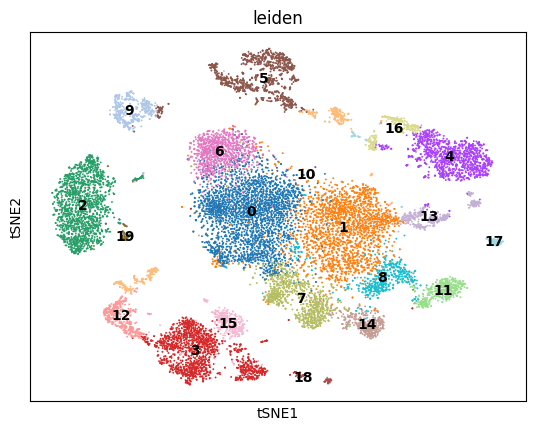

In [14]:
sc.pl.tsne(data, color="leiden",legend_loc="on data")